In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# Generating the data
N = 100
L = 1000
T = 20
x = np.empty((N,L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1/T).astype(np.float32)

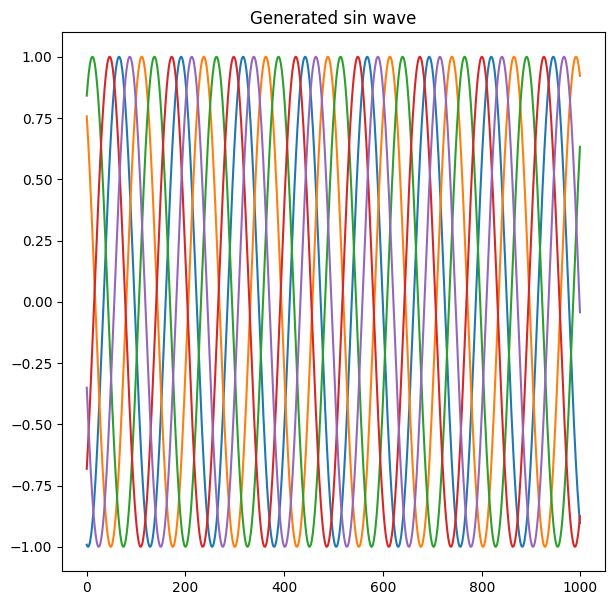

In [9]:
plt.figure(figsize=(7,7))
plt.title("Generated sin wave")
for i in range(5):
    plt.plot(np.arange(x.shape[1]), y[i,:])
plt.show()

In [10]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor,self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden,1)
        
    def forward(self, x, future=0): # future vaule is the number of further prediction
        outputs = []
        n_sample = x.size(0)
        h_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs, dim=1)
        return outputs
    
class LSTMPredictor2(nn.Module): # this scrip used to train the model with GPU
    def __init__(self, n_hidden=51):
        super(LSTMPredictor2,self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1,self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden,1)
        
    def forward(self, x, future=0): # future vaule is the number of further prediction
        outputs = []
        n_sample = x.size(0)
        h_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        c_t = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        h_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(n_sample, self.n_hidden, dtype=torch.float32).to(device)
        
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        outputs = torch.cat(outputs, dim=1)
        return outputs
        

In [11]:
def draw(y_i,color):
    plt.plot(np.arange(n), y_i[:n],color,linewidth=2.0)
    plt.plot(np.arange(n,n+future), y_i[n:], color+":", linewidth=2.0)

In [ ]:
# y=100 , 1000
train_input = torch.from_numpy(y[3:,:-1]).to(device) #91, 999
train_target = torch.from_numpy(y[3:,1:]).to(device) #97, 999
test_input = torch.from_numpy(y[:3,:-1]).to(device) #3, 999
test_target = torch.from_numpy(y[:3,1:]).to(device) #3, 999

model = LSTMPredictor2()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr= 0.8)


n_iters = 100

for i in range(n_iters):
    print("Step",i)
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criterion(out, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    
    if i % 10 == 0:
        with torch.no_grad():
            future = 1000
            pred = model(test_input,future=1000)
            loss = criterion(pred[:,:-future], test_target)
            pred = pred.to("cpu") # move data from GPU to cpu
            y = pred.detach().numpy()
        plt.figure(figsize=(12,6))
        plt.title(f"Train step {i+1}")
        n = train_input.shape[1]
        draw(y[0],'r')
        draw(y[1],'g')
        draw(y[2],'b')
    
    


Step 0
loss 0.4948929250240326
loss 0.4921265244483948
loss 0.4249597489833832
loss 0.21251212060451508
loss 89.61023712158203
loss 1.1308073997497559
loss 0.28095319867134094
loss 0.06365090608596802
loss 0.030373787507414818
loss 0.020928120240569115
loss 0.019596150144934654
loss 0.019407173618674278
loss 0.019183769822120667
loss 0.018622366711497307
loss 0.017425118014216423
loss 0.015068101696670055
loss 0.01094552967697382
loss 0.003343580523505807
loss 0.002812308492138982
loss 0.0018359726527705789
Step 1
loss 0.0017307604430243373
loss 0.001633520470932126
loss 0.0015821326524019241
loss 0.0014462773688137531
loss 0.0011718159075826406
loss 0.000792905455455184
loss 0.0005353277083486319
loss 0.00047106470447033644
loss 0.00046471128007397056
loss 0.0004627094021998346
loss 0.0004570581659208983
loss 0.00044476514449343085
loss 0.00041368528036400676
loss 0.000362255668733269
loss 0.00032638583797961473
loss 0.00028479177854023874
loss 0.0002505677111912519
loss 0.00022826709

Step 88
loss 5.512683401320828e-06
Step 89
loss 5.512683401320828e-06
Step 90
loss 5.512683401320828e-06
Step 91
loss 5.512683401320828e-06
Step 92
loss 5.512683401320828e-06
Step 93
loss 5.512683401320828e-06
Step 94
loss 5.512683401320828e-06
Step 95
loss 5.512683401320828e-06
Step 96
loss 5.512683401320828e-06
Step 97
loss 5.512683401320828e-06
Step 98
loss 5.512683401320828e-06
Step 99
loss 5.512683401320828e-06


In [ ]:
train_input.shape

In [11]:
train_input.shape

torch.Size([97, 999])

In [17]:
a = train_input.split(1,dim=1)

In [19]:
a[0].shape

torch.Size([97, 1])

In [87]:
test = model(torch.tensor([[1]],dtype=torch.float32).to(device),future=100)

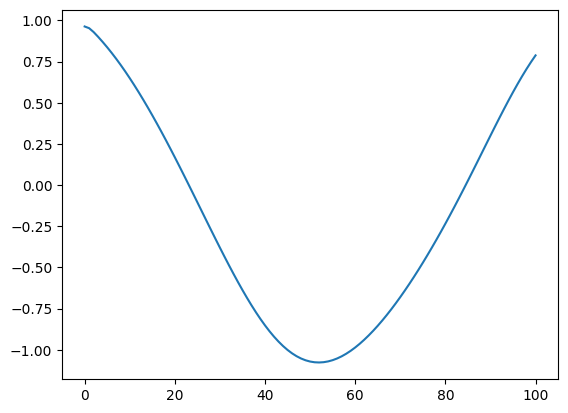

In [88]:
test = test.to("cpu").detach().numpy()
plt.plot(np.arange(len(test[0])),test[0])
plt.show()